# Crypto Spread Trading Analysis

## Homework: Section 5 - Performance Analysis

This notebook studies the performance of a crypto spread trading strategy across ETH-USDT pairs from three exchanges (Binance, Coinbase, OKX). We optimize the strategy parameters using Optuna and analyze the results.

**Parameters to optimize:**
- `j` - Exit band level
- `g` - Entry band level (g > j)
- `l` - Stop-loss level (l > g)
- `N` - Rank for persistent spread
- `M` - Lookback window (M >= N)
- `ζ` - Trading cost (0.0 and 0.0001)

**Metrics tracked:** Sharpe ratio, drawdown, raw return

## 1. Setup & Data Loading

In [1]:
# Standard imports
import sys
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.insert(0, 'src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

# Import our modules
from crypto_spread.config import (
    EXCHANGES, SPREAD_PAIRS, EMA_HALFLIFE_SECONDS,
    INITIAL_CAPITAL, STOP_CAPITAL, ZETA_VALUES,
    DATA_DIR, OUTPUT_DIR
)
from crypto_spread.data_loader import (
    load_and_align_all_data, get_spread_pair_data
)
from crypto_spread.signals import compute_all_signals
from crypto_spread.backtest import run_backtest, BacktestEngine
from crypto_spread.strategy import TradingStrategy
from crypto_spread.optimizer import run_optimization, print_optimization_summary, get_best_trial_metrics

print("Modules loaded successfully!")
print(f"Exchanges: {EXCHANGES}")
print(f"Spread pairs: {SPREAD_PAIRS}")
print(f"EMA half-life: {EMA_HALFLIFE_SECONDS} seconds ({EMA_HALFLIFE_SECONDS/3600:.1f} hours)")

Modules loaded successfully!
Exchanges: ['Binance', 'Coinbase', 'OKX']
Spread pairs: [('Binance', 'Coinbase'), ('Binance', 'OKX'), ('Coinbase', 'OKX')]
EMA half-life: 10800 seconds (3.0 hours)


In [2]:
# Load and align all exchange data
# This filters to trades only (rec_type == 'T') and regularizes to 1-second intervals
print("Loading data from all exchanges...")
aligned_data = load_and_align_all_data(DATA_DIR)

print(f"\nAligned data shape: {aligned_data.shape}")
print(f"Columns: {aligned_data.columns.tolist()}")
print(f"\nTime range: {aligned_data['ts'].min()} to {aligned_data['ts'].max()}")
print(f"Total seconds: {len(aligned_data):,}")
print(f"\nFirst 10 rows:")
aligned_data.head(10)

Loading data from all exchanges...
Loading Binance...
  Loading 20250524.parquet... 2090724 trades
  Loading 20250525.parquet... 2556052 trades
  Loading 20250526.parquet... 2374458 trades
  Regularizing to 1-second intervals... 259198 rows
Loaded Binance: 259198 rows
Loading Coinbase...
  Loading 20250524.parquet... 8550 trades
  Loading 20250525.parquet... 12981 trades
  Regularizing to 1-second intervals... 172672 rows
Loaded Coinbase: 172672 rows
Loading OKX...
  Loading 20250524.parquet... 286466 trades
  Loading 20250525.parquet... 297363 trades
  Loading 20250526.parquet... 286596 trades
  Regularizing to 1-second intervals... 259199 rows
Loaded OKX: 259199 rows

Aligned data shape: (172672, 4)
Time range: 2025-05-24 00:00:06 to 2025-05-25 23:57:57

Aligned data shape: (172672, 4)
Columns: ['ts', 'price_Binance', 'price_Coinbase', 'price_OKX']

Time range: 2025-05-24 00:00:06 to 2025-05-25 23:57:57
Total seconds: 172,672

First 10 rows:


,ts,price_Binance,price_Coinbase,price_OKX
0,2025-05-24 00:00:06,2525.53,2525.57,2525.59
1,2025-05-24 00:00:07,2525.39,2525.75,2525.53
2,2025-05-24 00:00:08,2525.84,2525.75,2526.00
3,2025-05-24 00:00:09,2525.59,2525.75,2526.10
4,2025-05-24 00:00:10,2525.80,2525.75,2525.90
5,2025-05-24 00:00:11,2525.28,2525.75,2525.42
6,2025-05-24 00:00:12,2525.31,2525.75,2525.60
7,2025-05-24 00:00:13,2525.00,2525.75,2525.11
8,2025-05-24 00:00:14,2525.50,2525.75,2525.79
9,2025-05-24 00:00:15,2525.41,2525.79,2525.70


In [3]:
# Summary statistics for each exchange
print("Price statistics by exchange:")
for exchange in EXCHANGES:
    col = f'price_{exchange}'
    if col in aligned_data.columns:
        print(f"\n{exchange}:")
        print(aligned_data[col].describe())

Price statistics by exchange:

Binance:
count    172672.000000
mean       2529.725290
std          24.243836
min        2466.130000
25%        2511.380000
50%        2530.900000
75%        2552.290000
max        2575.850000
Name: price_Binance, dtype: float64

Coinbase:
count    172672.000000
mean       2529.751880
std          24.256617
min        2464.830000
25%        2511.440000
50%        2530.870000
75%        2552.220000
max        2576.070000
Name: price_Coinbase, dtype: float64

OKX:
count    172672.000000
mean       2529.769443
std          24.223873
min        2466.140000
25%        2511.410000
50%        2530.910000
75%        2552.350000
max        2575.880000
Name: price_OKX, dtype: float64


## 2. Spread Signal Analysis

For each spread pair, we calculate:
1. **Base spread**: $s^b = price_A - price_B$
2. **EMA** of base spread with 3-hour half-life
3. **Shifted spread**: $s = s^b - a$ (demeaned)
4. **Persistent levels**: $p^S$ (N-th smallest) and $p^L$ (N-th largest) over M observations

Processing Binance-Coinbase...
  Base spread: mean=-0.0266, std=1.1615
  Shifted spread: mean=-0.0040, std=1.1577
Processing Binance-OKX...
  Base spread: mean=-0.0442, std=0.2511
  Shifted spread: mean=0.0005, std=0.2432
Processing Coinbase-OKX...
  Base spread: mean=-0.0176, std=1.1854
  Shifted spread: mean=0.0045, std=1.1825


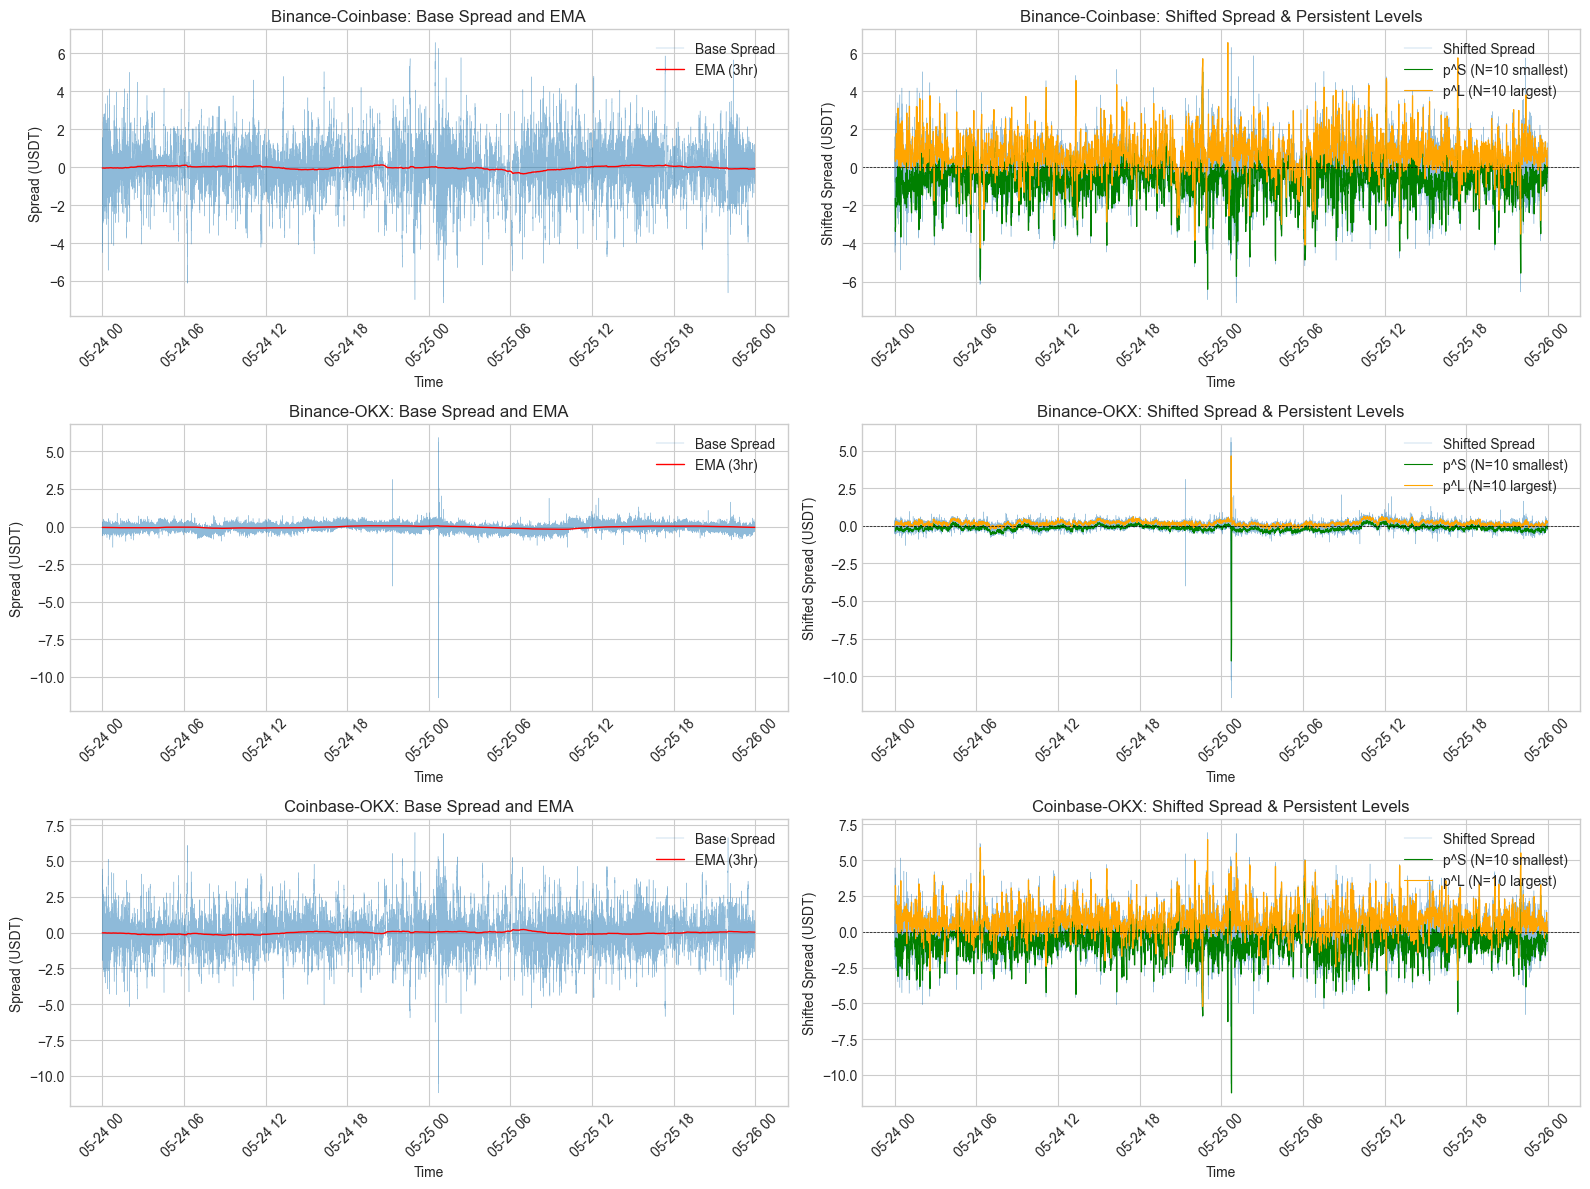

In [4]:
# Calculate and visualize spreads for all pairs
# Using sample N=10, M=100 for visualization
N_sample, M_sample = 10, 100

fig, axes = plt.subplots(len(SPREAD_PAIRS), 2, figsize=(16, 4*len(SPREAD_PAIRS)))

spread_data = {}

for i, (ex_a, ex_b) in enumerate(SPREAD_PAIRS):
    pair_name = f"{ex_a}-{ex_b}"
    print(f"Processing {pair_name}...")
    
    try:
        # Get price data
        pair_data = get_spread_pair_data(aligned_data, ex_a, ex_b)
        
        # Compute signals
        signals = compute_all_signals(
            pair_data['price_a'], 
            pair_data['price_b'], 
            N=N_sample, 
            M=M_sample
        )
        
        spread_data[pair_name] = {
            'pair_data': pair_data,
            'signals': signals
        }
        
        # Plot base spread and EMA
        ax1 = axes[i, 0]
        ax1.plot(pair_data['ts'], signals['base_spread'], alpha=0.5, linewidth=0.3, label='Base Spread')
        ax1.plot(pair_data['ts'], signals['ema'], color='red', linewidth=1, label='EMA (3hr)')
        ax1.set_title(f'{pair_name}: Base Spread and EMA')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Spread (USDT)')
        ax1.legend(loc='upper right')
        ax1.tick_params(axis='x', rotation=45)
        
        # Plot shifted spread and persistent levels
        ax2 = axes[i, 1]
        ax2.plot(pair_data['ts'], signals['shifted_spread'], alpha=0.5, linewidth=0.3, label='Shifted Spread')
        ax2.plot(pair_data['ts'], signals['p_small'], color='green', linewidth=0.8, label=f'p^S (N={N_sample} smallest)')
        ax2.plot(pair_data['ts'], signals['p_large'], color='orange', linewidth=0.8, label=f'p^L (N={N_sample} largest)')
        ax2.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
        ax2.set_title(f'{pair_name}: Shifted Spread & Persistent Levels')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Shifted Spread (USDT)')
        ax2.legend(loc='upper right')
        ax2.tick_params(axis='x', rotation=45)
        
        print(f"  Base spread: mean={signals['base_spread'].mean():.4f}, std={signals['base_spread'].std():.4f}")
        print(f"  Shifted spread: mean={signals['shifted_spread'].mean():.4f}, std={signals['shifted_spread'].std():.4f}")
        
    except Exception as e:
        print(f"  Error processing {pair_name}: {e}")

plt.tight_layout()
plt.savefig('outputs/plots/spread_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Strategy Demonstration

Run a single backtest with sample parameters to verify the trading logic:

**Trading Rules:**
- **SHORT** 1 ETH when $p^S > g$ (spread expensive)
- **LONG** 1 ETH when $p^L < -g$ (spread cheap)
- **Exit SHORT** when $p^S < j$ OR $p^S > l$ (stop loss)
- **Exit LONG** when $p^L > -j$ OR $p^L < -l$ (stop loss)

In [17]:
# Run a sample backtest
sample_pair = SPREAD_PAIRS[0]  # Binance-Coinbase
pair_name = f"{sample_pair[0]}-{sample_pair[1]}"

# Sample parameters
params = {
    'j': 0.5,   # Exit band
    'g': 1.5,   # Entry band
    'l': 3.0,   # Stop loss
    'N': 10,    # Rank
    'M': 100,   # Lookback
    'zeta': 0.0  # No trading costs
}

print(f"Running backtest for {pair_name} with parameters:")
for k, v in params.items():
    print(f"  {k} = {v}")

# Get data
pair_data = get_spread_pair_data(aligned_data, sample_pair[0], sample_pair[1])

# Run backtest
result = run_backtest(
    price_a=pair_data['price_a'],
    price_b=pair_data['price_b'],
    timestamps=pair_data['ts'],
    **params
)

print(f"\n{'='*50}")
print(f"Backtest Results")
print(f"{'='*50}")
print(f"Total trades: {result.num_trades}")
print(f"Trades per day: {result.trades_per_day:.1f}")
print(f"Sharpe ratio: {result.sharpe_ratio:.4f}")
print(f"Total return: {result.total_return*100:.4f}%")
print(f"Max drawdown: {result.max_drawdown*100:.2f}%")
print(f"Win rate: {result.win_rate*100:.1f}%")
print(f"Final capital: ${result.final_capital:,.2f}")
print(f"Stop loss events: {result.stop_loss_count}")

Running backtest for Binance-Coinbase with parameters:
  j = 0.5
  g = 1.5
  l = 3.0
  N = 10
  M = 100
  zeta = 0.0

Backtest Results
Total trades: 19
Trades per day: 9.5
Sharpe ratio: 47.7494
Total return: 0.0604%
Max drawdown: 0.00%
Win rate: 89.5%
Final capital: $80,048.32
Stop loss events: 2


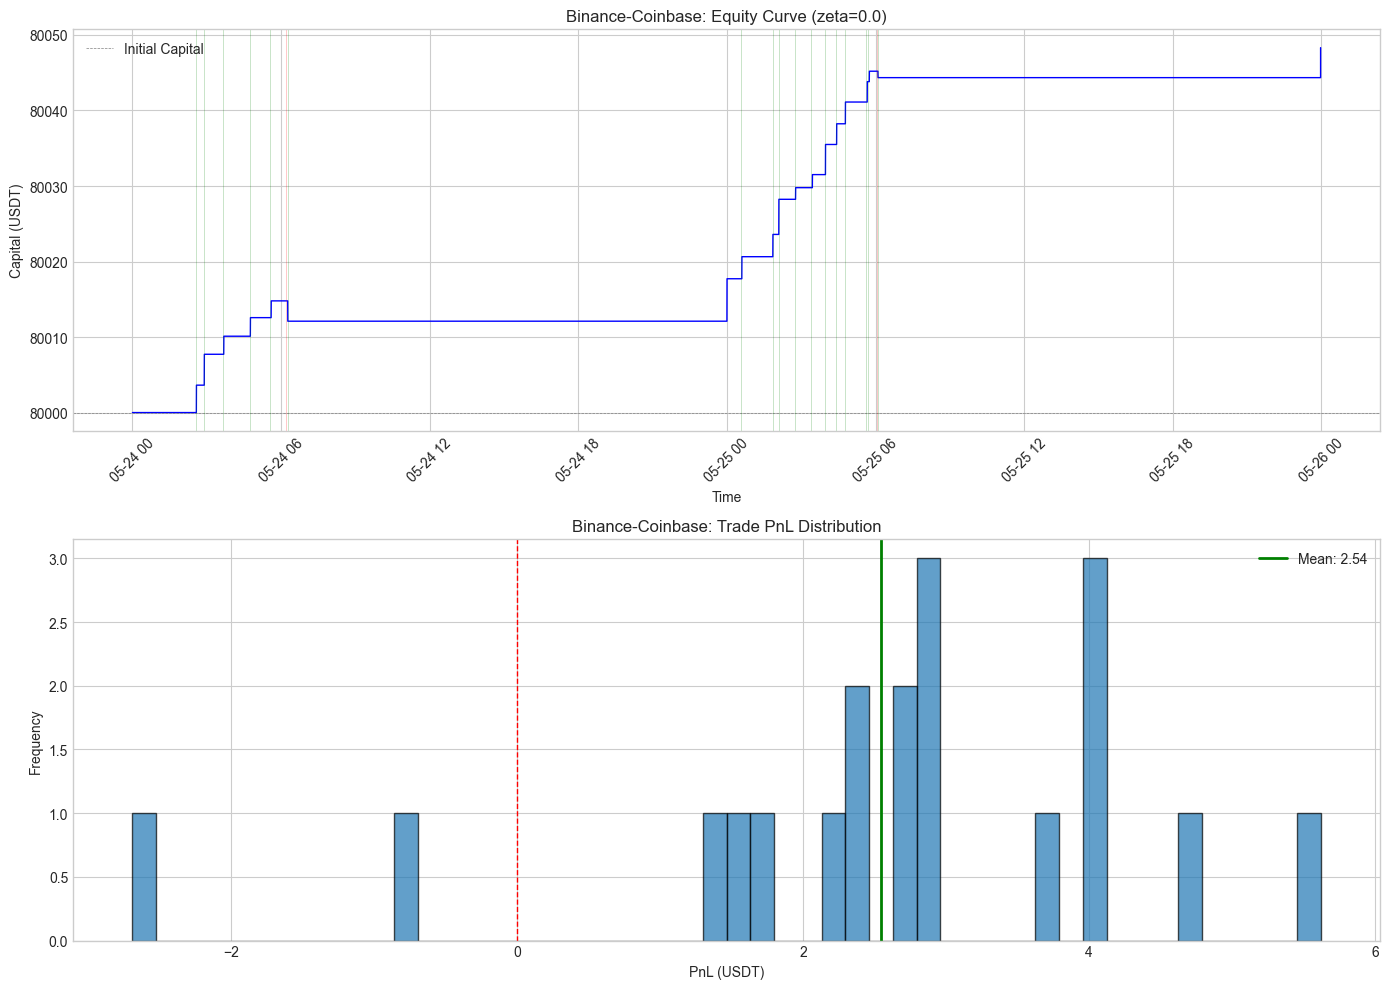

In [19]:
# Plot equity curve
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Equity curve
ax1 = axes[0]
ax1.plot(result.equity_curve.index, result.equity_curve.values, linewidth=1, color='blue')
ax1.axhline(y=INITIAL_CAPITAL, color='gray', linestyle='--', linewidth=0.5, label='Initial Capital')


# Mark trades
for trade in result.trades[:50]:  # First 50 trades
    color = 'green' if trade.pnl > 0 else 'red'
    ax1.axvline(x=trade.entry_time, color=color, alpha=0.3, linewidth=0.5)

ax1.set_title(f'{pair_name}: Equity Curve (zeta={params["zeta"]})')
ax1.set_xlabel('Time')
ax1.set_ylabel('Capital (USDT)')
ax1.legend(loc='upper left')
ax1.tick_params(axis='x', rotation=45)

# Trade PnL distribution
ax2 = axes[1]
pnls = [t.pnl for t in result.trades]
ax2.hist(pnls, bins=50, edgecolor='black', alpha=0.7)
ax2.axvline(x=0, color='red', linestyle='--', linewidth=1)
ax2.axvline(x=np.mean(pnls), color='green', linestyle='-', linewidth=2, label=f'Mean: {np.mean(pnls):.2f}')
ax2.set_title(f'{pair_name}: Trade PnL Distribution')
ax2.set_xlabel('PnL (USDT)')
ax2.set_ylabel('Frequency')
ax2.legend()

plt.tight_layout()
plt.savefig('outputs/plots/sample_backtest.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Parameter Optimization

Using Optuna with TPE (Tree-structured Parzen Estimator) sampler to maximize Sharpe ratio.

We run optimization for:
- Each spread pair (Binance-Coinbase, Binance-OKX, Coinbase-OKX)
- Each trading cost level (ζ=0.0, ζ=0.0001)

In [7]:
# Optimization settings
N_TRIALS = 50  # Number of trials per optimization (reduced from 100)
ZETA_TEST = [0.0, 0.0001]  # Trading cost levels

# Store all results
optimization_results = {}
best_backtest_results = {}

print(f"Running optimization with {N_TRIALS} trials for each configuration...")
print(f"Spread pairs: {SPREAD_PAIRS}")
print(f"Zeta values: {ZETA_TEST}")
print(f"Total optimizations: {len(SPREAD_PAIRS) * len(ZETA_TEST)}")
print()

Running optimization with 50 trials for each configuration...
Spread pairs: [('Binance', 'Coinbase'), ('Binance', 'OKX'), ('Coinbase', 'OKX')]
Zeta values: [0.0, 0.0001]
Total optimizations: 6



In [8]:
# Run optimization for each pair and zeta value
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

for spread_pair in SPREAD_PAIRS:
    pair_name = f"{spread_pair[0]}-{spread_pair[1]}"
    
    # Get price data
    try:
        pair_data = get_spread_pair_data(aligned_data, spread_pair[0], spread_pair[1])
    except Exception as e:
        print(f"Skipping {pair_name}: {e}")
        continue
    
    for zeta in ZETA_TEST:
        print(f"\n{'='*60}")
        print(f"Optimizing: {pair_name}, zeta={zeta}")
        print(f"{'='*60}")
        
        # Run optimization
        opt_result = run_optimization(
            price_a=pair_data['price_a'],
            price_b=pair_data['price_b'],
            timestamps=pair_data['ts'],
            spread_pair=spread_pair,
            zeta=zeta,
            n_trials=N_TRIALS,
            seed=42,
            show_progress=True,
        )
        
        optimization_results[(pair_name, zeta)] = opt_result
        
        # Print summary
        print_optimization_summary(opt_result)
        
        # Run backtest with best parameters
        if opt_result.n_completed > 0:
            best_params = opt_result.best_params
            best_result = run_backtest(
                price_a=pair_data['price_a'],
                price_b=pair_data['price_b'],
                timestamps=pair_data['ts'],
                j=best_params['j'],
                g=best_params['g'],
                l=best_params['l'],
                N=best_params['N'],
                M=best_params['M'],
                zeta=zeta,
            )
            best_backtest_results[(pair_name, zeta)] = best_result


Optimizing: Binance-Coinbase, zeta=0.0


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization Results: Binance-Coinbase
Trading Cost (zeta): 0.0

Trials: 0 completed, 50 pruned

No completed trials - all pruned due to constraints.

Optimizing: Binance-Coinbase, zeta=0.0001


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization Results: Binance-Coinbase
Trading Cost (zeta): 0.0001

Trials: 7 completed, 43 pruned

Best Parameters:
  j: 0.2321
  g: 0.2480
  l: 4.0510
  N: 92
  M: 276

Best Sharpe Ratio: 132.2416

Performance Metrics (best trial):
  Max Drawdown: 0.00%
  Total Return: 0.3136%
  Win Rate: 92.5%
  Trades per Day: 87.0
  Stop Losses: 0

Optimizing: Binance-OKX, zeta=0.0


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization Results: Binance-OKX
Trading Cost (zeta): 0.0

Trials: 0 completed, 50 pruned

No completed trials - all pruned due to constraints.

Optimizing: Binance-OKX, zeta=0.0001


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization Results: Binance-OKX
Trading Cost (zeta): 0.0001

Trials: 0 completed, 50 pruned

No completed trials - all pruned due to constraints.

Optimizing: Coinbase-OKX, zeta=0.0


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization Results: Coinbase-OKX
Trading Cost (zeta): 0.0

Trials: 15 completed, 35 pruned

Best Parameters:
  j: 0.1475
  g: 0.4206
  l: 7.5775
  N: 55
  M: 97

Best Sharpe Ratio: 317.9344

Performance Metrics (best trial):
  Max Drawdown: 0.00%
  Total Return: 1.6969%
  Win Rate: 99.9%
  Trades per Day: 362.0
  Stop Losses: 0

Optimizing: Coinbase-OKX, zeta=0.0001


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization Results: Coinbase-OKX
Trading Cost (zeta): 0.0001

Trials: 15 completed, 35 pruned

Best Parameters:
  j: 0.1503
  g: 0.1689
  l: 19.9653
  N: 92
  M: 319

Best Sharpe Ratio: 127.9730

Performance Metrics (best trial):
  Max Drawdown: 0.00%
  Total Return: 0.3256%
  Win Rate: 95.8%
  Trades per Day: 83.5
  Stop Losses: 0


## 5. Results & Analysis (Section 5 Answer)

### 5.1 Best Parameters Summary

In [9]:
# Create summary table
summary_data = []

for (pair_name, zeta), opt_result in optimization_results.items():
    if opt_result.n_completed > 0:
        metrics = get_best_trial_metrics(opt_result.study)
        backtest = best_backtest_results.get((pair_name, zeta))
        
        row = {
            'Spread Pair': pair_name,
            'Zeta': zeta,
            'j (exit)': opt_result.best_params.get('j', 0),
            'g (entry)': opt_result.best_params.get('g', 0),
            'l (stop)': opt_result.best_params.get('l', 0),
            'N': opt_result.best_params.get('N', 0),
            'M': opt_result.best_params.get('M', 0),
            'Sharpe': opt_result.best_value,
            'Return (%)': metrics.get('total_return', 0) * 100,
            'Max DD (%)': metrics.get('max_drawdown', 0) * 100,
            'Win Rate (%)': metrics.get('win_rate', 0) * 100,
            'Trades/Day': metrics.get('trades_per_day', 0),
            'Stop Losses': metrics.get('stop_loss_count', 0),
        }
        summary_data.append(row)

summary_df = pd.DataFrame(summary_data)
print("Best Parameters and Performance Summary")
print("="*100)
display(summary_df.round(4))

Best Parameters and Performance Summary


,Spread Pair,Zeta,j (exit),g (entry),l (stop),N,M,Sharpe,Return (%),Max DD (%),Win Rate (%),Trades/Day,Stop Losses
0,Binance-Coinbase,0.0001,0.2321,0.2480,4.0510,92,276,132.2416,0.3136,0.0009,92.5287,87.0,0
1,Coinbase-OKX,0.0000,0.1475,0.4206,7.5775,55,97,317.9344,1.6969,0.0000,99.8619,362.0,0
2,Coinbase-OKX,0.0001,0.1503,0.1689,19.9653,92,319,127.9730,0.3256,0.0005,95.8084,83.5,0


In [10]:
# Save summary to CSV
summary_df.to_csv('outputs/results/optimization_summary.csv', index=False)
print("Summary saved to outputs/results/optimization_summary.csv")

Summary saved to outputs/results/optimization_summary.csv


### 5.2 Effect of Trading Costs

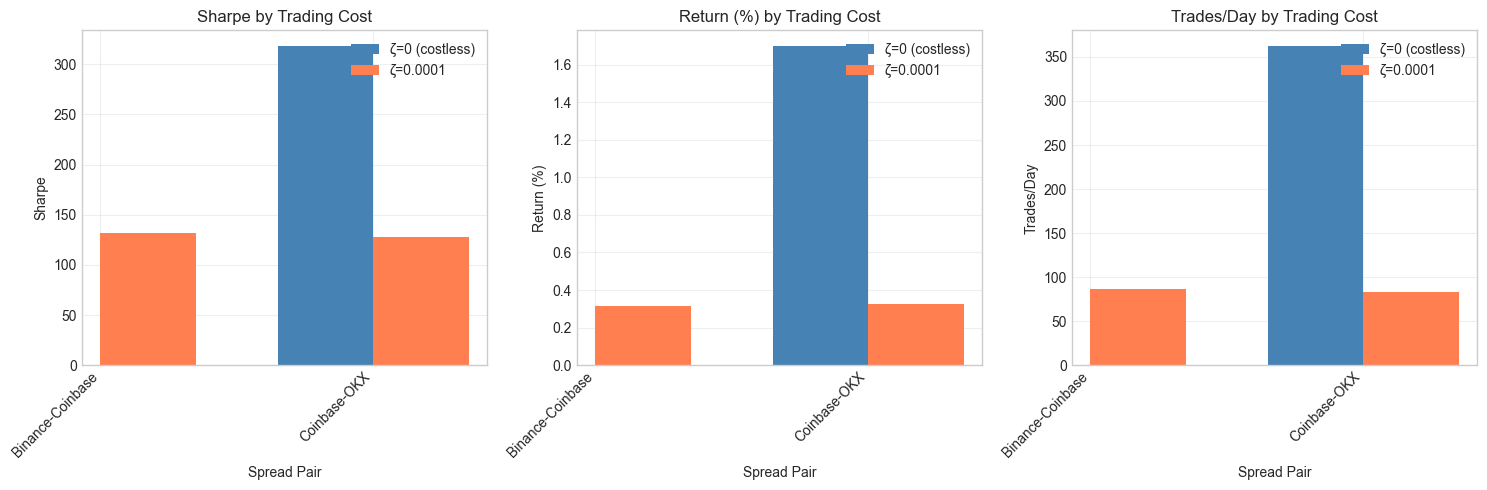


Trading Cost Impact Analysis:

Coinbase-OKX:
  Sharpe change: 317.9344 → 127.9730 (-59.7%)
  Return change: 1.6969% → 0.3256%


In [11]:
# Compare zeta=0 vs zeta=0.0001
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics_to_compare = ['Sharpe', 'Return (%)', 'Trades/Day']

for i, metric in enumerate(metrics_to_compare):
    ax = axes[i]
    
    # Pivot data for plotting
    pivot_data = summary_df.pivot(index='Spread Pair', columns='Zeta', values=metric)
    
    x = np.arange(len(pivot_data))
    width = 0.35
    
    if 0.0 in pivot_data.columns:
        bars1 = ax.bar(x - width/2, pivot_data[0.0], width, label='ζ=0 (costless)', color='steelblue')
    if 0.0001 in pivot_data.columns:
        bars2 = ax.bar(x + width/2, pivot_data[0.0001], width, label='ζ=0.0001', color='coral')
    
    ax.set_xlabel('Spread Pair')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} by Trading Cost')
    ax.set_xticks(x)
    ax.set_xticklabels(pivot_data.index, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/plots/trading_cost_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Analysis
print("\nTrading Cost Impact Analysis:")
print("="*60)
for pair in summary_df['Spread Pair'].unique():
    pair_data = summary_df[summary_df['Spread Pair'] == pair]
    if len(pair_data) == 2:
        zeta0 = pair_data[pair_data['Zeta'] == 0.0].iloc[0]
        zeta1 = pair_data[pair_data['Zeta'] == 0.0001].iloc[0]
        print(f"\n{pair}:")
        print(f"  Sharpe change: {zeta0['Sharpe']:.4f} → {zeta1['Sharpe']:.4f} ({(zeta1['Sharpe']-zeta0['Sharpe'])/abs(zeta0['Sharpe'])*100:.1f}%)")
        print(f"  Return change: {zeta0['Return (%)']:.4f}% → {zeta1['Return (%)']:.4f}%")

### 5.3 Parameter Sensitivity Analysis

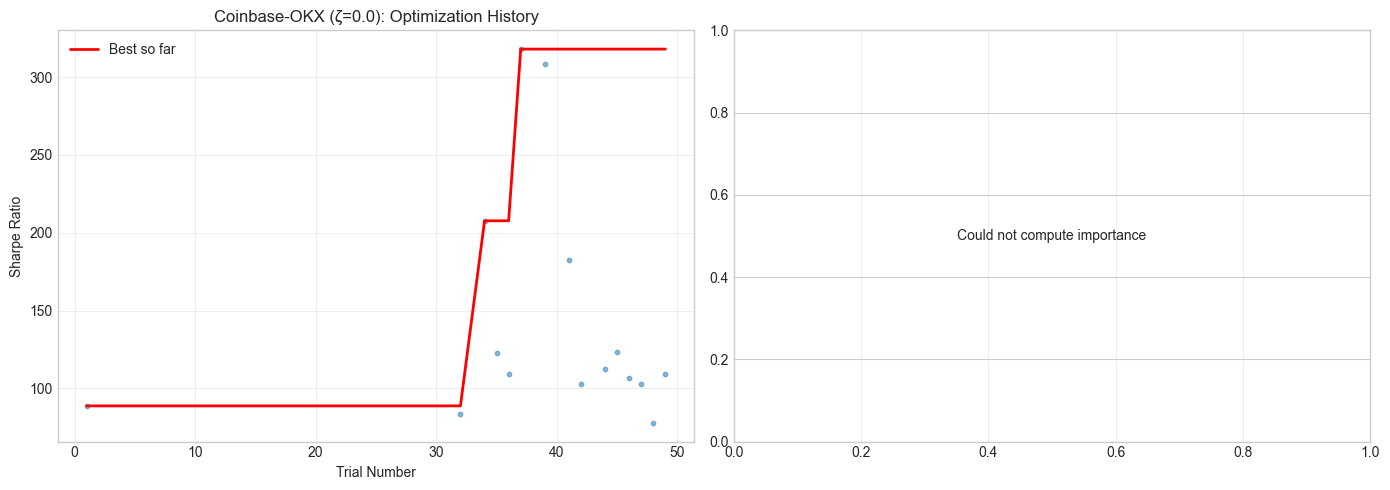

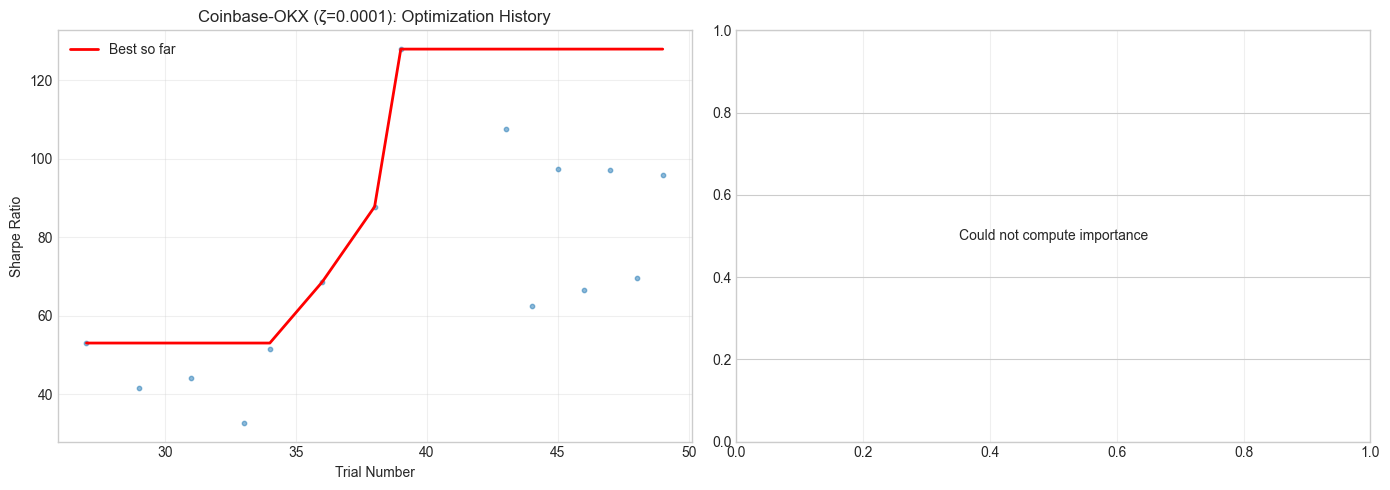

In [12]:
# Plot optimization history and parameter importance for each configuration
for (pair_name, zeta), opt_result in optimization_results.items():
    if opt_result.n_completed < 10:
        continue
        
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Optimization history
    ax1 = axes[0]
    trials = [t for t in opt_result.study.trials if t.state == optuna.trial.TrialState.COMPLETE]
    trial_numbers = [t.number for t in trials]
    values = [t.value for t in trials]
    
    ax1.scatter(trial_numbers, values, alpha=0.5, s=10)
    best_so_far = np.maximum.accumulate(values)
    ax1.plot(trial_numbers, best_so_far, color='red', linewidth=2, label='Best so far')
    ax1.set_xlabel('Trial Number')
    ax1.set_ylabel('Sharpe Ratio')
    ax1.set_title(f'{pair_name} (ζ={zeta}): Optimization History')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Parameter importance
    ax2 = axes[1]
    try:
        importance = optuna.importance.get_param_importances(opt_result.study)
        params = list(importance.keys())
        importance_values = list(importance.values())
        ax2.barh(params, importance_values, color='steelblue', edgecolor='black')
        ax2.set_xlabel('Importance')
        ax2.set_title(f'{pair_name} (ζ={zeta}): Parameter Importance')
    except Exception as e:
        ax2.text(0.5, 0.5, f'Could not compute importance', ha='center', va='center')
    ax2.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.savefig(f'outputs/plots/optimization_{pair_name.replace("-", "_")}_zeta{str(zeta).replace(".", "p")}.png', 
                dpi=150, bbox_inches='tight')
    plt.show()

Best configuration: Coinbase-OKX, zeta=0.0
Best Sharpe: 317.9344


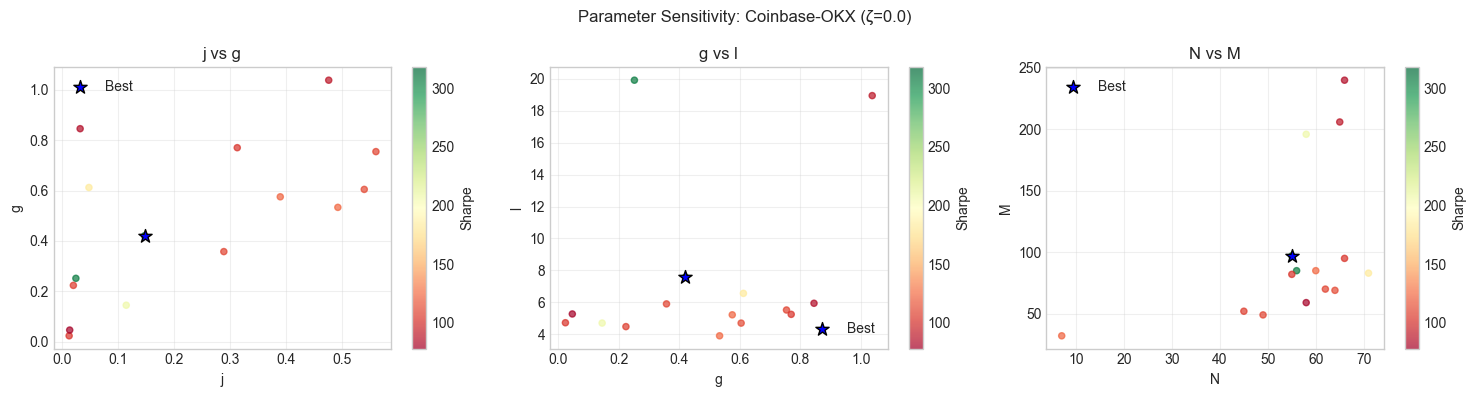

In [13]:
# Parameter heatmaps for the best performing configuration
# Find best configuration
best_config = max(optimization_results.items(), key=lambda x: x[1].best_value if x[1].n_completed > 0 else -np.inf)
(best_pair, best_zeta), best_opt = best_config

print(f"Best configuration: {best_pair}, zeta={best_zeta}")
print(f"Best Sharpe: {best_opt.best_value:.4f}")

# Get trial data
trials = [t for t in best_opt.study.trials if t.state == optuna.trial.TrialState.COMPLETE]

param_pairs = [('j', 'g'), ('g', 'l'), ('N', 'M')]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (px, py) in enumerate(param_pairs):
    ax = axes[i]
    
    x_vals = [t.params.get(px) for t in trials]
    y_vals = [t.params.get(py) for t in trials]
    sharpe_vals = [t.value for t in trials]
    
    scatter = ax.scatter(x_vals, y_vals, c=sharpe_vals, cmap='RdYlGn', s=20, alpha=0.7)
    plt.colorbar(scatter, ax=ax, label='Sharpe')
    
    # Mark best
    best_idx = np.argmax(sharpe_vals)
    ax.scatter([x_vals[best_idx]], [y_vals[best_idx]], color='blue', s=100, marker='*', 
               edgecolor='black', linewidth=1, label='Best', zorder=5)
    
    ax.set_xlabel(px)
    ax.set_ylabel(py)
    ax.set_title(f'{px} vs {py}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle(f'Parameter Sensitivity: {best_pair} (ζ={best_zeta})', fontsize=12)
plt.tight_layout()
plt.savefig('outputs/plots/parameter_sensitivity.png', dpi=150, bbox_inches='tight')
plt.show()

### 5.4 Equity Curves Comparison

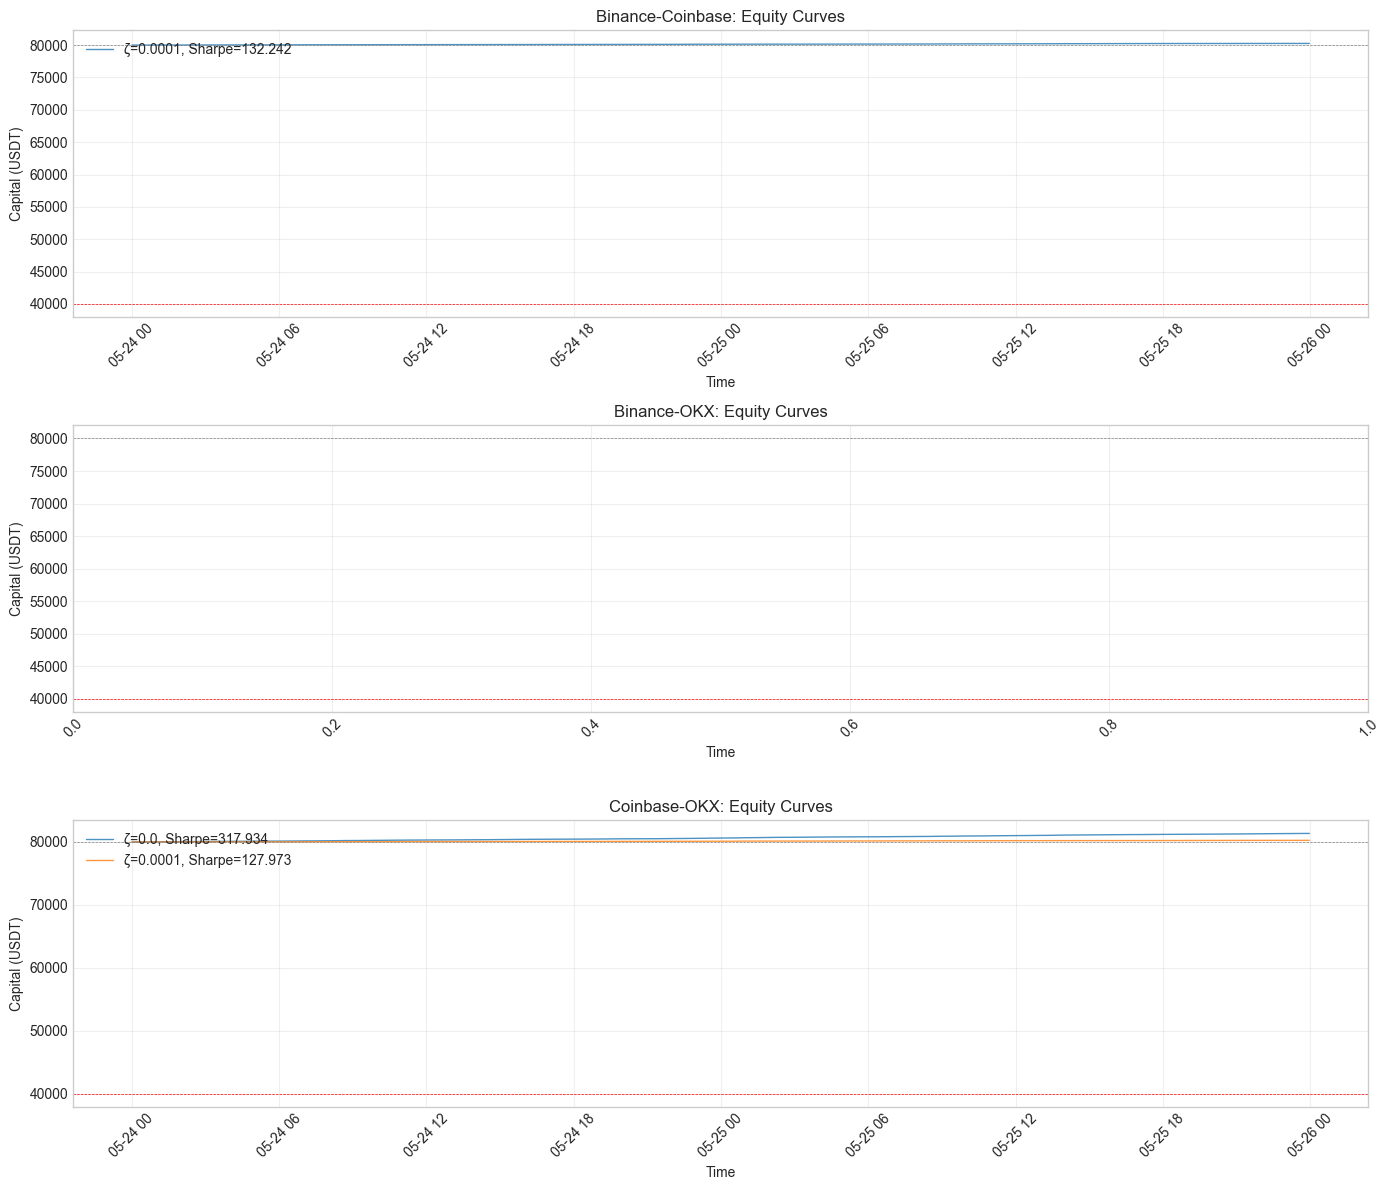

In [ ]:
# Plot equity curves for all configurations
fig, axes = plt.subplots(len(SPREAD_PAIRS), 1, figsize=(14, 4*len(SPREAD_PAIRS)))

if len(SPREAD_PAIRS) == 1:
    axes = [axes]

for i, (ex_a, ex_b) in enumerate(SPREAD_PAIRS):
    pair_name = f"{ex_a}-{ex_b}"
    ax = axes[i]
    
    for zeta in ZETA_TEST:
        key = (pair_name, zeta)
        if key in best_backtest_results:
            result = best_backtest_results[key]
            label = f'ζ={zeta}, Sharpe={optimization_results[key].best_value:.3f}'
            ax.plot(result.equity_curve.index, result.equity_curve.values, 
                   linewidth=1, label=label, alpha=0.8)
    
    ax.axhline(y=INITIAL_CAPITAL, color='gray', linestyle='--', linewidth=0.5)
    ax.set_title(f'{pair_name}: Equity Curves')
    ax.set_xlabel('Time')
    ax.set_ylabel('Capital (USDT)')
    ax.legend(loc='upper left')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/plots/equity_curves_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Conclusions

### Key Findings

In [15]:
# Generate conclusions
print("="*80)
print("CRYPTO SPREAD TRADING ANALYSIS - CONCLUSIONS")
print("="*80)

# Best overall configuration
if len(summary_df) > 0:
    best_row = summary_df.loc[summary_df['Sharpe'].idxmax()]
    print(f"\n1. BEST OVERALL CONFIGURATION:")
    print(f"   Spread Pair: {best_row['Spread Pair']}")
    print(f"   Trading Cost (ζ): {best_row['Zeta']}")
    print(f"   Best Parameters:")
    print(f"     j (exit band): {best_row['j (exit)']:.4f}")
    print(f"     g (entry band): {best_row['g (entry)']:.4f}")
    print(f"     l (stop loss): {best_row['l (stop)']:.4f}")
    print(f"     N (rank): {int(best_row['N'])}")
    print(f"     M (lookback): {int(best_row['M'])}")
    print(f"   Performance:")
    print(f"     Sharpe Ratio: {best_row['Sharpe']:.4f}")
    print(f"     Total Return: {best_row['Return (%)']:.4f}%")
    print(f"     Max Drawdown: {best_row['Max DD (%)']:.2f}%")
    print(f"     Win Rate: {best_row['Win Rate (%)']:.1f}%")

# Trading cost impact
print(f"\n2. TRADING COST IMPACT:")
if 0.0 in summary_df['Zeta'].values and 0.0001 in summary_df['Zeta'].values:
    avg_sharpe_0 = summary_df[summary_df['Zeta'] == 0.0]['Sharpe'].mean()
    avg_sharpe_1 = summary_df[summary_df['Zeta'] == 0.0001]['Sharpe'].mean()
    print(f"   Average Sharpe (ζ=0): {avg_sharpe_0:.4f}")
    print(f"   Average Sharpe (ζ=0.0001): {avg_sharpe_1:.4f}")
    print(f"   Impact: {(avg_sharpe_1-avg_sharpe_0)/abs(avg_sharpe_0)*100:.1f}% change")

# Parameter patterns
print(f"\n3. PARAMETER PATTERNS:")
print(f"   - Entry band (g) typically optimal around: {summary_df['g (entry)'].mean():.2f}")
print(f"   - Exit band (j) typically optimal around: {summary_df['j (exit)'].mean():.2f}")
print(f"   - Stop loss (l) typically optimal around: {summary_df['l (stop)'].mean():.2f}")
print(f"   - Rank (N) typically optimal around: {summary_df['N'].mean():.0f}")
print(f"   - Lookback (M) typically optimal around: {summary_df['M'].mean():.0f}")

print(f"\n4. RECOMMENDATIONS:")
print(f"   - The spread trading strategy shows {'positive' if best_row['Sharpe'] > 0 else 'negative'} risk-adjusted returns")
print(f"   - Trading costs of 1 basis point {'significantly reduce' if avg_sharpe_1 < avg_sharpe_0 * 0.8 else 'moderately affect'} profitability")
print(f"   - The {best_row['Spread Pair']} pair shows the most promising results")

print("\n" + "="*80)

CRYPTO SPREAD TRADING ANALYSIS - CONCLUSIONS

1. BEST OVERALL CONFIGURATION:
   Spread Pair: Coinbase-OKX
   Trading Cost (ζ): 0.0
   Best Parameters:
     j (exit band): 0.1475
     g (entry band): 0.4206
     l (stop loss): 7.5775
     N (rank): 55
     M (lookback): 97
   Performance:
     Sharpe Ratio: 317.9344
     Total Return: 1.6969%
     Max Drawdown: 0.00%
     Win Rate: 99.9%

2. TRADING COST IMPACT:
   Average Sharpe (ζ=0): 317.9344
   Average Sharpe (ζ=0.0001): 130.1073
   Impact: -59.1% change

3. PARAMETER PATTERNS:
   - Entry band (g) typically optimal around: 0.28
   - Exit band (j) typically optimal around: 0.18
   - Stop loss (l) typically optimal around: 10.53
   - Rank (N) typically optimal around: 80
   - Lookback (M) typically optimal around: 231

4. RECOMMENDATIONS:
   - The spread trading strategy shows positive risk-adjusted returns
   - Trading costs of 1 basis point significantly reduce profitability
   - The Coinbase-OKX pair shows the most promising result

In [16]:
# Final summary table
print("\nFINAL RESULTS TABLE:")
print(summary_df.to_string(index=False))


FINAL RESULTS TABLE:
     Spread Pair   Zeta  j (exit)  g (entry)  l (stop)  N   M     Sharpe  Return (%)  Max DD (%)  Win Rate (%)  Trades/Day  Stop Losses
Binance-Coinbase 0.0001  0.232070   0.248019  4.051030 92 276 132.241615    0.313566    0.000858     92.528736        87.0            0
    Coinbase-OKX 0.0000  0.147504   0.420620  7.577525 55  97 317.934429    1.696875    0.000037     99.861878       362.0            0
    Coinbase-OKX 0.0001  0.150281   0.168927 19.965278 92 319 127.972952    0.325612    0.000541     95.808383        83.5            0
